In [1]:
using JuMP, Gurobi
using CSV, LinearAlgebra, DataFrames
using Plots
using DelimitedFiles

In [2]:
path = "C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/";

In [3]:
#load social and ecological data and orgnize 
FL = repeat([Float64], inner=15)
dtype = append!([String], FL);

regional_EF = CSV.File(string(path,"EF_SC31.csv"),header=1,delim=",", types=dtype) |> DataFrame    
capacity = CSV.File(string(path,"capacity31.csv"),header=1,delim=",", types=dtype) |> DataFrame    
distance = CSV.File(string(path,"distance31.csv"),header=1,delim=",") |> DataFrame 
LCA_model = CSV.File(string(path,"LCA_model.csv"), header=1, delim=",") |> DataFrame 
SDD = CSV.File(string(path,"SDD31.csv"),header=1,delim=",") |> DataFrame;

In [4]:
global_sink = 1.099e10                        # global pub (ocean) CO2 sequestration (ton/yr)
global_sink_tot = 2.236e10                  # global total (ocean+land) CO2 sequestration (ton/yr)
global_emi = 3.53e10                          # global CO2 emission (ton/yr)                          # 2021 global GD ($/yr)
es_ratio = global_sink/global_emi

emission_c = SDD[!, "emission"]          # national CO2 emission (ton/yr)
sink_c = SDD[!, "sink ton/yr"]           # national CO2 sink (ton/yr)
Dsoc = SDD[!, "Dsoc ton/yr"]           # national CO2 sink (ton/yr)

EF_trans = 1.005/10000                        # ton CO2/km*ton (The average freight truck in the U.S. emits 161.8 grams of CO2 per ton-mile)
process = LCA_model[!,"process"]
countries = capacity[!,"country"]
ncty = size(countries,1)                          # No. of countries
nproc = size(process,1);                          # No. of processes 

mkt_loc = findfirst(isequal("United States"), countries)
mkt_proc = findfirst(isequal("battery"), process)

# seperate model
cathode = collect(1:4)
cell = collect(5:10)
noncell = [12,13]
battery = [11,14]
scaler = LCA_model[!,"scaler"];

In [5]:
cell_demand = 0.001*164.98*(1.369*1e6)*2;           # annual demand of Li battery for tesla (1.369M EV/yr, ~2 NMC111 pack/EV, 164.98 kg/pack (35kwh/pack), 80~100 kWh per EV)

----

### Build Model

In [6]:
function EO_SS_Model(objfunc)
    model = Model(Gurobi.Optimizer)
    @variable(model, x[1:ncty, 1:nproc] >= 0)
    @variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0)
    
    x_cth = [@constraint(model, sum(x[i,k] for i in 1:ncty) == sum(x[i,5] for i in 1:ncty) * scaler[k]) for k in cathode]
    x_cell = [@constraint(model, sum(x[i,k] for i in 1:ncty) == sum(x[i,11] for i in 1:ncty) * scaler[k]) for k in cell]
    x_noncell = [@constraint(model, sum(x[i,k] for i in 1:ncty) == sum(x[i,14] for i in 1:ncty) * scaler[k]) for k in noncell]
    x_battery = [@constraint(model, sum(x[i,k] for i in 1:ncty) == sum(x[i,15] for i in 1:ncty) * scaler[k]) for k in battery];

    cstr_cap = [@constraint(model, x[i,k] <= capacity[!, 2:end][i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_op = [@constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_cth = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5]*scaler[k]) for k in cathode for j in 1:ncty]
    cstr_cell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11]*scaler[k]) for k in cell for j in 1:ncty]
    cstr_noncell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14]*scaler[k]) for k in noncell for j in 1:ncty]
    cstr_battery = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15]*scaler[k]) for k in battery for j in 1:ncty]
    
    @constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)
    tmp = filter!(e->e!=mkt_loc,collect(1:ncty))
    for j in tmp
        @constraint(model, sum(y[i,j,mkt_proc] for i in 1:ncty) == 0);
    end
    
    
    # obj func calculation
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1)  # ncty*1 matrix
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1)  # ncty*1 matrix

    transS = Vector{AffExpr}(undef, ncty)
    transD = Vector{AffExpr}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq += arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        end
        transD[j] = arc_emi  # ncty*1 matrix
        transS[j] = arc_seq  # ncty*1 matrix
    end

    Allo_soc = proD ./ emission_c .* Dsoc
    
    
    SS = sum(Allo_soc - (proD + transD))
    EO = sum(proD - proS + transD)
    
    
    if objfunc == "Ecological"
        @objective(model, Min, EO);
    else
        @objective(model, Min, SS);
    end
      
    JuMP.optimize!(model)

    opt_x = JuMP.value.(x)
    opt_y = JuMP.value.(y)
    opt_obj = JuMP.objective_value(model);
    result = Dict(["opt_x"=>opt_x, "opt_obj"=>opt_obj, "opt_y"=>opt_y])
    return result
end

EO_SS_Model (generic function with 1 method)

In [7]:
res_eo = EO_SS_Model("Ecological")

Academic license - for non-commercial use only - expires 2024-12-26
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1409 rows, 14880 columns and 31062 nonzeros
Model fingerprint: 0x058cb9de
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [4e-03, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1160 rows and 13492 columns
Presolve time: 0.03s
Presolved: 249 rows, 1388 columns, 2818 nonzeros

Ordering time: 0.00s

Barrier performed 0 iterations in 0.03 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 58 iterations and 0.03 seconds
Optimal objective  9.05

Dict{String, Any} with 3 entries:
  "opt_y"   => [0.0 0.0 … 0.0 6200.0; 0.0 0.0 … 0.0 270.292; … ; 0.0 0.0 … 0.0 …
  "opt_obj" => 9.05237e5
  "opt_x"   => [6200.0 0.0 … 0.0 0.0; 270.292 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 …

In [8]:
res_ss = EO_SS_Model("Social")

Academic license - for non-commercial use only - expires 2024-12-26
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1409 rows, 14880 columns and 31062 nonzeros
Model fingerprint: 0x305319b0
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1160 rows and 13492 columns
Presolve time: 0.03s
Presolved: 249 rows, 1388 columns, 2818 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.747e+03
 Factor NZ  : 4.612e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.096e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iteratio

Dict{String, Any} with 3 entries:
  "opt_y"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.…
  "opt_obj" => -1.31711e7
  "opt_x"   => [6200.0 0.0 … 0.0 0.0; 770.292 7000.0 … 0.0 0.0; … ; 0.0 0.0 … 0…

In [12]:
eo_x = DataFrame(res_eo["opt_x"],:auto)
rename!(eo_x,process)
eo_x.index = countries;
# CSV.write("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/result/EO_optX_0401.csv", eo_x)

In [13]:
ss_x = DataFrame(res_ss["opt_x"],:auto)
rename!(ss_x,process)
ss_x.index = countries;
# CSV.write("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/result/SS_optX_0401.csv", ss_x)

### Get Extreme Points

In [14]:
EO1 = res_eo["opt_obj"]
SS1 = res_ss["opt_obj"]
ss_x = res_ss["opt_x"]
ss_y = res_ss["opt_y"]
eo_x = res_eo["opt_x"]
eo_y = res_eo["opt_y"];

In [41]:
function net_emi(x,y)
    
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1) 
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1) 
    
    transS = Vector{Float64}(undef, ncty)
    transD = Vector{Float64}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq += arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        end
        transD[j] = arc_emi  # ncty*1 matrix
        transS[j] = arc_seq  # ncty*1 matrix
    end
    
    EO = proD - proS + transD
    return(sum(EO))
end
    

net_emi (generic function with 1 method)

In [21]:
function soc_ss(x,y)
    
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1)  # ncty*1 matrix
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1)  # ncty*1 matrix

    
    transS = Vector{Float64}(undef, ncty)
    transD = Vector{Float64}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
            arc_seq += arc_emi * (sink_c[j]/emission_c[j] + es_ratio)
        end
        transD[j] = arc_emi  # ncty*1 matrix
        transS[j] = arc_seq  # ncty*1 matrix
    end

    
    EO = sum(proD - proS + transD) 
    Allo_soc = proD ./ emission_c .* Dsoc
    SS = sum(Allo_soc - (proD + transD));
    
    return sum(SS)
end
    

soc_ss (generic function with 1 method)

In [48]:
function country_EO(x,y)
    
    proD = (x .* Matrix(regional_EF[:,2:end]))
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = x .* pro_sink
    
    
    transD = zeros(ncty, nproc)
    for k in 1:nproc
        for j in 1:ncty
            emi = 0
            for i in 1:ncty
                emi += y[i,j,k] * distance[!, 2:end][i,j] * EF_trans
            end
            transD[j,k] = emi
        end
    end
    
    
    EO = proD - proS + transD
    return proD + transD, proS
end

country_EO (generic function with 1 method)

In [56]:
MD, MS = country_EO(ss_x,ss_y)

MD ./ MS

31×15 Matrix{Float64}:
   1.47952   NaN         NaN        …  NaN        NaN         NaN
   1.38012     1.38012   NaN           NaN        NaN         NaN
   1.02121   NaN           1.02121     NaN        NaN         NaN
 NaN           0.645049  NaN           NaN        NaN         NaN
   0.476861  NaN         NaN            Inf         0.476861  NaN
 NaN           2.64607   NaN        …  NaN        NaN         NaN
 NaN         NaN         NaN           NaN        NaN         NaN
 NaN           1.24966   NaN           NaN        NaN         NaN
 NaN           0.520455  NaN           NaN        NaN         NaN
 NaN         NaN         NaN           NaN        NaN         NaN
 NaN         NaN         NaN        …  NaN        NaN         NaN
 NaN         NaN         NaN           NaN        NaN         NaN
 NaN           1.59091   NaN           NaN        NaN         NaN
   ⋮                                ⋱                         
 NaN         NaN         NaN           NaN        NaN   

In [75]:
function country_SS(x, y, tp="consumer")

    proD = (x .* Matrix(regional_EF[:,2:end]))

    Allo_soc = proD ./ emission_c .* Dsoc
    
    transD = zeros(ncty, nproc)
    if tp == "consumer"
        for k in 1:nproc
            for j in 1:ncty
                emi = 0
                for i in 1:ncty
                    emi += y[i,j,k] * distance[!, 2:end][i,j] * EF_trans
                end
                transD[j,k] = emi
            end
        end
    else
        for k in 1:nproc
            for i in 1:ncty
                emi = 0
                for j in 1:ncty
                    emi += y[i,j,k] * distance[!, 2:end][i,j] * EF_trans
                end
                transD[i,k] = emi
            end
        end
    end

    SS_M = Allo_soc - (proD + transD)

    idx = []
    for i in 1:ncty
        for k in 1:nproc
            if SS_M[i,k] > 0
                push!(idx, [i,k])
            end
        end
    end
    
    return Allo_soc, proD, transD, idx
    
end

country_SS (generic function with 2 methods)

In [76]:
AD1, PD1, TD1, uss1 = country_SS(eo_x, eo_y, "customer")

([452.1201629327902 0.0 … 0.0 0.0; 25.51839008754615 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 39.57894736842105 0.0 … 1606.098631111111 59341.11784421052], [14322.0 0.0 … 0.0 0.0; 648.6998153568129 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 2115.0 0.0 … 85825.8956 3.1710409847999997e6], [5636.637384463592 0.0 … 0.0 0.0; 398.0680644614152 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Any[])

In [77]:
AD2, PD2, TD2, uss2 = country_SS(eo_x, eo_y, "consumer")

([452.1201629327902 0.0 … 0.0 0.0; 25.51839008754615 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 39.57894736842105 0.0 … 1606.098631111111 59341.11784421052], [14322.0 0.0 … 0.0 0.0; 648.6998153568129 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 2115.0 0.0 … 85825.8956 3.1710409847999997e6], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 41449.80271397623 85912.76842424828 … 0.0 0.0], Any[])

In [73]:
AD1 - PD1 -TD1

31×15 Matrix{Float64}:
 -19506.5            0.0        …       0.0       0.0   0.0
  -1021.25           0.0                0.0       0.0   0.0
  -6354.85           0.0                0.0       0.0   0.0
  -1190.8           -1.22941e5          0.0       0.0   0.0
     -1.2268e5       0.0                0.0       0.0   0.0
      0.0            0.0        …       0.0       0.0   0.0
      0.0            0.0                0.0       0.0   0.0
      0.0           -1.11095e6          0.0       0.0   0.0
      0.0       -42679.8                0.0       0.0   0.0
      0.0            0.0                0.0       0.0   0.0
      0.0            0.0        …       0.0       0.0   0.0
      0.0            0.0                0.0       0.0   0.0
      0.0            0.0                0.0       0.0   0.0
      ⋮                         ⋱                      
      0.0            0.0                0.0       0.0   0.0
      0.0            0.0        …       0.0       0.0   0.0
      0.0            

In [74]:
AD2 - PD2 -TD2

31×15 Matrix{Float64}:
 -13869.9         0.0             0.0        …       0.0       0.0   0.0
   -623.181       0.0             0.0                0.0       0.0   0.0
  -4722.48        0.0            -1.58479e5          0.0       0.0   0.0
  -1069.01       -1.22186e5       0.0                0.0       0.0   0.0
 -89471.5         0.0             0.0                0.0       0.0   0.0
      0.0         0.0             0.0        …       0.0       0.0   0.0
      0.0         0.0             0.0                0.0       0.0   0.0
      0.0        -1.02955e6       0.0                0.0       0.0   0.0
      0.0    -41847.5             0.0                0.0       0.0   0.0
      0.0         0.0             0.0                0.0       0.0   0.0
      0.0         0.0             0.0        …       0.0       0.0   0.0
      0.0         0.0             0.0                0.0       0.0   0.0
      0.0         0.0             0.0                0.0       0.0   0.0
      ⋮                     

In [55]:
# Obj_EO at sol_soc*

EO2 = net_emi(ss_x, ss_y)

7.671101386127347e6

In [56]:
# Obj_SS at sol_eco*

SS2 = soc_ss(eo_x, eo_y)

-9.16961495628337e6

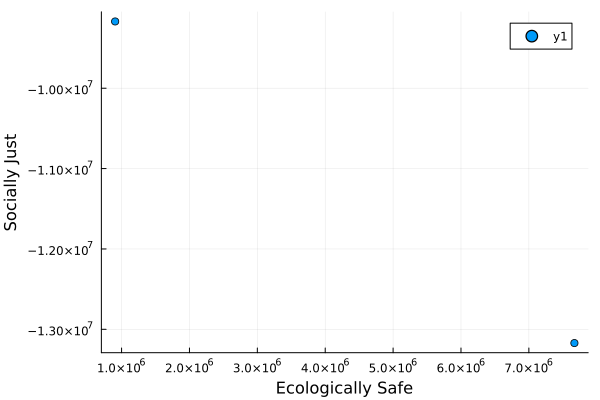

In [57]:
x_axis = [EO1, EO2]
y_axis = [SS2, SS1]

# plot(x_axis, y_axis)
# plot!(x_axis, y_axis, seriestype=:scatter)
scatter(x_axis, y_axis)

# title!("Over the whole supply chain (ϵ-constraint)")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")

----

### Pareto Front Plot

In [58]:
function cal_intm(EO_m)
    model = Model(Gurobi.Optimizer)
    set_silent(model)
    @variable(model, x[1:ncty, 1:nproc] >= 0)           
    @variable(model, y[1:ncty, 1:ncty, 1:nproc] >= 0)
    
    
    cstr_cap = [@constraint(model, x[i,k] <= capacity[!, 2:end][i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_op = [@constraint(model, sum(y[i,j,k] for j in 1:ncty) == x[i,k]) for k in 1:nproc for i in 1:ncty]
    cstr_cth = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,5]*scaler[k]) for k in cathode for j in 1:ncty]
    cstr_cell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,11]*scaler[k]) for k in cell for j in 1:ncty]
    cstr_noncell = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,14]*scaler[k]) for k in noncell for j in 1:ncty]
    cstr_battery = [@constraint(model, sum(y[i,j,k] for i in 1:ncty) == x[j,15]*scaler[k]) for k in battery for j in 1:ncty]
    
    @constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)
    tmp = filter!(e->e!=mkt_loc,collect(1:ncty))
    for j in tmp
        @constraint(model, sum(y[i,j,mkt_proc] for i in 1:ncty) == 0);
    end
    
#     @constraint(model, sum(y[i,mkt_loc,mkt_proc] for i in 1:ncty) == cell_demand)
#     for j in 1:ncty-1
#         @constraint(model, sum(y[i,j,mkt_proc] for i in 1:ncty) == 0)
#     end
    
    
    # obj func calculation
    proD = (x .* Matrix(regional_EF[:,2:end])) * ones(nproc,1)  # ncty*1 matrix
    pro_sink = zeros(ncty, nproc)
    for k in 1:nproc
        for i in 1:ncty
            pro_sink[i,k] = regional_EF[i, k+1] * (sink_c[i]/emission_c[i] + es_ratio)
        end
    end
    proS = (x.*pro_sink)*ones(nproc,1)  # ncty*1 matrix

    
    transD = Vector{AffExpr}(undef, ncty)
    for j in 1:ncty
        arc_emi = 0
        arc_seq = 0
        for i in 1:ncty
            amount = sum(y[i,j,k] for k in 1:nproc)
            arc_emi += amount * distance[!, 2:end][i,j] * EF_trans
        end
        transD[j] = arc_emi  # ncty*1 matrix
    end
    
    Allo_soc = proD ./ emission_c .* Dsoc
    SS = Allo_soc - (proD + transD)
    
    EO = sum(proD - proS + transD)
    @constraint(model, EO==EO_m)
    
    @objective(model, Min, sum(SS));

    JuMP.optimize!(model)
    opt_obj = JuMP.objective_value(model)
    
    return opt_obj
end
    

cal_intm (generic function with 1 method)

In [59]:
function ep_constraint(N, EO1, EO2)
    
    ep = (EO2 - EO1) / N
    lsss = []
    lseo = []
    for i in 0:N
        EO_m = EO1 + i*ep
        obj_ss = cal_intm(EO_m)
        push!(lsss, obj_ss)
        push!(lseo, EO_m)
    end
    
    return lsss, lseo
end
        

ep_constraint (generic function with 1 method)

In [60]:
ls_ss, ls_eo = ep_constraint(4, EO1, EO2)

Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26


(Any[-9.16961495628338e6, -1.1249843181737576e7, -1.2291016115949703e7, -1.2840372863405662e7, -1.3171065447874242e7], Any[905237.170677799, 2.596703224540186e6, 4.288169278402573e6, 5.97963533226496e6, 7.671101386127347e6])

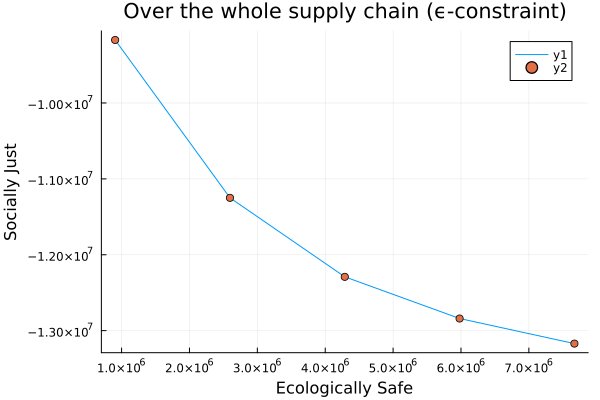

In [61]:
x_axis = ls_eo
y_axis = ls_ss

plot(x_axis, y_axis)
plot!(x_axis, y_axis, seriestype=:scatter)
# scatter(x_axis, y_axis)

title!("Over the whole supply chain (ϵ-constraint)")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")

In [62]:
perato1 = DataFrame([ls_eo, ls_ss],:auto)
rename!(perato1,["EO", "SS"])
CSV.write("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/result/PERATO_0401.csv", perato1)

"C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/result/PERATO_0401.csv"

### Tesla Case

In [63]:
tesla_soc = -1.034e7
tesla_eco = 3.614e6;

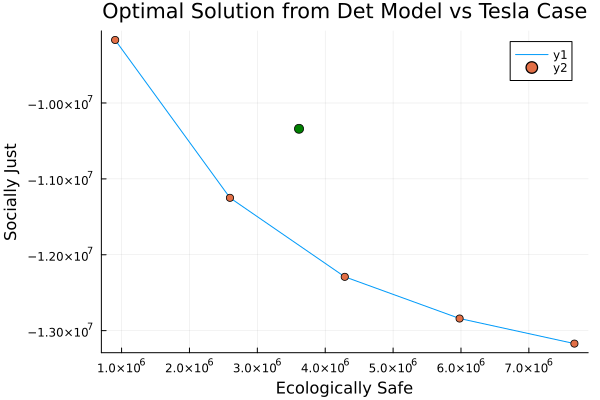

In [64]:
x_axis = ls_eo
y_axis = ls_ss

plot(x_axis, y_axis)
plot!(x_axis, y_axis, seriestype=:scatter)
scatter!([tesla_eco], [tesla_soc], color = "green", label = "", markersize = 5)

title!("Optimal Solution from Det Model vs Tesla Case")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")

---

In [65]:
path = "C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/Tesla/";

In [66]:
#load social and ecological data and orgnize 
regional_EF = CSV.File(string(path,"EF_SC.csv"),header=1,delim=",", types=dtype) |> DataFrame 
capacity = CSV.File(string(path,"capacity.csv"),header=1,delim=",", types=dtype) |> DataFrame    
distance = CSV.File(string(path,"distance.csv"),header=1,delim=",") |> DataFrame 
SDD = CSV.File(string(path,"SDD.csv"),header=1,delim=",") |> DataFrame;

In [67]:
emission_c = SDD[!, "D"]         
sink_c = SDD[!, "S"]           
Dsoc = SDD[!, "Dsoc"]          

countries = capacity[!,"country"]
ncty = size(countries,1)                       
nproc = size(process,1);                         

mkt_loc = findfirst(isequal("United States"), countries)
mkt_proc = findfirst(isequal("battery"), process);

In [68]:
emission_c = SDD[!, "D"]          # national CO2 emission (ton/yr)
sink_c = SDD[!, "S"]           # national CO2 sink (ton/yr)
Dsoc = SDD[!, "Dsoc"]           # national CO2 sink (ton/yr)

countries = capacity[!,"country"]
ncty = size(countries,1)                          # No. of countries
nproc = size(process,1);                          # No. of processes 

mkt_loc = findfirst(isequal("United States"), countries)
mkt_proc = findfirst(isequal("battery"), process);

In [69]:
tesla_eo = EO_SS_Model("Ecological")

Academic license - for non-commercial use only - expires 2024-12-26
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 554 rows, 2340 columns and 5184 nonzeros
Model fingerprint: 0x0c56b797
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 416 rows and 1947 columns
Presolve time: 0.00s
Presolved: 138 rows, 393 columns, 962 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3339040e+06   3.838389e+05   0.000000e+00      0s
      45    1.3363448e+06   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.00 seconds
Optimal objective  1.336344810e+06

User-callback calls 88, time in user-callback 0.00 sec


Dict{String, Any} with 3 entries:
  "opt_y"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 48270.3; … ; 0.0 0.0 … 0.0 0.0…
  "opt_obj" => 1.33634e6
  "opt_x"   => [0.0 0.0 … 0.0 0.0; 48270.3 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…

In [70]:
tesla_ss = EO_SS_Model("Social")

Academic license - for non-commercial use only - expires 2024-12-26
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 554 rows, 2340 columns and 5184 nonzeros
Model fingerprint: 0xd706de45
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 416 rows and 1947 columns
Presolve time: 0.00s
Presolved: 138 rows, 393 columns, 962 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.5118538e+07   3.753092e+06   0.000000e+00      0s
     139   -1.2276735e+07   0.000000e+00   0.000000e+00      0s

Solved in 139 iterations and 0.00 seconds
Optimal objective -1.227673453e+07

User-callback calls 182, time in user-callback 0.00 sec

Dict{String, Any} with 3 entries:
  "opt_y"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 48895.7 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "opt_obj" => -1.22767e7
  "opt_x"   => [0.0 0.0 … 0.0 0.0; 48895.7 7000.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 …

In [71]:
EO1_tesla = tesla_eo["opt_obj"]
SS1_tesla = tesla_ss["opt_obj"]
ss_x_tesla = tesla_ss["opt_x"]
ss_y_tesla = tesla_ss["opt_y"]
eo_x_tesla = tesla_eo["opt_x"]
eo_y_tesla = tesla_eo["opt_y"];

In [72]:
EO2_tesla = net_emi(ss_x_tesla, ss_y_tesla)
SS2_tesla = soc_ss(eo_x_tesla, eo_y_tesla);

In [73]:
tesla_ss, tesla_eo = ep_constraint(4, EO1_tesla, EO2_tesla)

Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26
Academic license - for non-commercial use only - expires 2024-12-26


(Any[-9.1934813271811e6, -1.0699242937837709e7, -1.1677720218908057e7, -1.2051640882783424e7, -1.227673452730028e7], Any[1.33634480957356e6, 2.6421255015690466e6, 3.947906193564533e6, 5.253686885560019e6, 6.559467577555506e6])

In [74]:
perato2 = DataFrame([tesla_eo, tesla_ss],:auto)
rename!(perato2,["EO", "SS"])
CSV.write("C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/result/PERATO_tesla.csv", perato2)

"C:/Users/bourg/.julia/environments/batterySC/Li-battery-SC/src/deterministic/data/result/PERATO_tesla.csv"

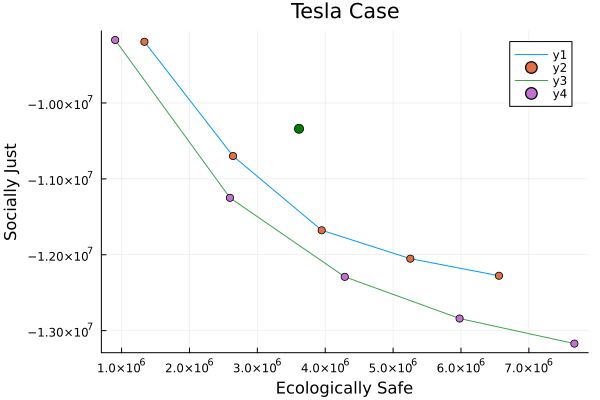

In [75]:
x_axis = tesla_eo
y_axis = tesla_ss

plot(x_axis, y_axis)
plot!(x_axis, y_axis, seriestype=:scatter)
plot!(ls_eo, ls_ss)
plot!(ls_eo, ls_ss, seriestype=:scatter)
scatter!([tesla_eco], [tesla_soc], color = "green", label = "", markersize = 5)

title!("Tesla Case")
xlabel!("Ecologically Safe")
ylabel!("Socially Just")

### Plots

In [48]:
xrange = [-3e6, 9e6]
yrange = [-1.5e7, 0.5e7];

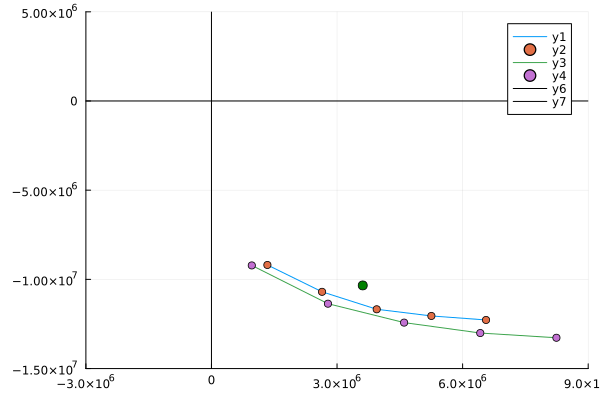

In [63]:
plot(x_axis, y_axis, xlims=xrange, ylims=yrange)
plot!(x_axis, y_axis, seriestype=:scatter)
plot!(ls_eo, ls_ss)
plot!(ls_eo, ls_ss, seriestype=:scatter)
scatter!([tesla_eco], [tesla_soc], color = "green", label = "", markersize = 5)
vline!([0], color=:black)
hline!([0], color=:black)